In [1]:
!pip install staticvectors

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import sys
import pickle

import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing # For StandardScaler
import sklearn.decomposition # For PCA
import matplotlib.pyplot as plt
from staticvectors import StaticVectors # Already imported above

sys.path.append('code')
sys.path.append("/jet/home/azhang19/stat 214/stat-214-lab3-group6/code")

import word_embedding # Imports the classes defined above if they are in word_embedding.py

# Define the base path for data access
data_path = '/ocean/projects/mth240012p/shared/data' # Path where data files are stored

In [3]:
# %% Load preprocessed word sequences (likely includes words and their timings)
with open(f'{data_path}/raw_text.pkl', 'rb') as file:
    wordseqs = pickle.load(file) # wordseqs is expected to be a dictionary: {story_id: WordSequenceObject}

# %% Get list of story identifiers and split into training and testing sets
# Assumes story data for 'subject2' exists and filenames are story IDs + '.npy'
stories = [i[:-4] for i in os.listdir(f'{data_path}/subject2')] # Extract story IDs from filenames
# Split stories into train and test sets with a fixed random state for reproducibility


# First, use 60% for training and 40% for the remaining data.
train_stories, temp_stories = train_test_split(stories, train_size=0.6, random_state=214)
# Then split the remaining 40% equally to get 20% validation and 20% test.
val_stories, test_stories = train_test_split(temp_stories, train_size=0.5, random_state=214)

#train, test = train[:10], test[:10] # For testing purposes, limit to first 10 stories in each set

In [4]:
class SafeStaticVectorsModel(word_embedding.StaticVectorsModel):
    """
    A safe wrapper around StaticVectorsModel that returns a zero vector
    for tokens not found in the pre-trained vocabulary to avoid negative seed errors.
    """
    def transform(self, text):
        """
        Transforms a list of words into a matrix of word embeddings.
        For unknown words (not in the vocabulary), returns a zero vector.
        
        Args:
            text (list): A list of tokens (words).
        
        Returns:
            np.ndarray: A 2D array with one row per token.
        """
        embeddings_list = []
        # Loop over tokens in the text
        for token in text:
            # Check if token exists in the pre-trained model's tokens dictionary
            if token in self.model.tokens:
                # Retrieve the embedding; self.model.embeddings() returns an array of shape (1, dim)
                emb = self.model.embeddings([token])
                embeddings_list.append(emb[0])
            else:
                # If token is unknown, return a zero vector (avoid calling generate() which can yield a negative seed)
                dim = self.model.config["dim"]
                embeddings_list.append(np.zeros(dim))
        return np.array(embeddings_list)

In [5]:
# Bag of Words
# 1. Fit a Bag-of-Words model on training stories.
bow_model = word_embedding.BagofWords().fit(
    [wordseqs[story].data for story in train_stories]
)

# 2. Create an aggregator to downsample, apply delays (TRs 1-4), standardize, and trim the first 5 and last 10 timepoints.
bow_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)

# 3. Generate downsampled BoW embeddings for all stories (train + validation + test).
all_stories = train_stories + val_stories + test_stories
bow_embedding = word_embedding.embed_sentences(all_stories, wordseqs, bow_model)

# 4. Aggregate features for each split.
X_train_bow = bow_aggregator.fit_transform(train_stories, bow_embedding)
X_val_bow   = bow_aggregator.transform(val_stories, bow_embedding)
X_test_bow  = bow_aggregator.transform(test_stories, bow_embedding)

print("BoW feature shapes:")
print("  X_train_bow:", X_train_bow.shape)
print("  X_val_bow:", X_val_bow.shape)
print("  X_test_bow:", X_test_bow.shape)

BoW feature shapes:
  X_train_bow: (20263, 19540)
  X_val_bow: (7064, 19540)
  X_test_bow: (7459, 19540)


In [6]:
# %% Word2Vec Feature Engineering Pipeline

# 1. Load pre-trained Word2Vec model
w2v_model_path = '/jet/home/azhang19/stat 214/stat-214-lab3-group6/data/word2vec' # Path to Word2Vec model
w2v_model = SafeStaticVectorsModel(w2v_model_path)
w2v_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)
w2v_embedding = word_embedding.embed_sentences(all_stories, wordseqs, w2v_model)
X_train_w2v = w2v_aggregator.fit_transform(train_stories, w2v_embedding)
X_val_w2v   = w2v_aggregator.transform(val_stories, w2v_embedding)
X_test_w2v  = w2v_aggregator.transform(test_stories, w2v_embedding)

print("Word2Vec feature shapes:")
print("  X_train_w2v:", X_train_w2v.shape)
print("  X_val_w2v:", X_val_w2v.shape)
print("  X_test_w2v:", X_test_w2v.shape)

Word2Vec feature shapes:
  X_train_w2v: (20263, 1200)
  X_val_w2v: (7064, 1200)
  X_test_w2v: (7459, 1200)


In [7]:
#GloVe

# 1. Load pre-trained GloVe model
glove_model_path = '/jet/home/azhang19/stat 214/stat-214-lab3-group6/data/glove-6B' # Path to GloVe model
glove_model = SafeStaticVectorsModel(glove_model_path)
glove_aggregator = word_embedding.embeddings_aggregator(
    delays=range(1, 5),
    standardize=True,
    trim_range=(5, -10)
)
glove_embedding = word_embedding.embed_sentences(all_stories, wordseqs, glove_model)
X_train_glove = glove_aggregator.fit_transform(train_stories, glove_embedding)
X_val_glove   = glove_aggregator.transform(val_stories, glove_embedding)
X_test_glove  = glove_aggregator.transform(test_stories, glove_embedding)

print("GloVe feature shapes:")
print("  X_train_glove:", X_train_glove.shape)
print("  X_val_glove:", X_val_glove.shape)
print("  X_test_glove:", X_test_glove.shape)

GloVe feature shapes:
  X_train_glove: (20263, 1200)
  X_val_glove: (7064, 1200)
  X_test_glove: (7459, 1200)


In [8]:
# %% Define a function to load fMRI data for specified stories and subjects
def load_fmri_data(stories, data_path):
    """
    Loads fMRI data (.npy files) for given stories and subjects.

    Args:
        stories (list): List of story identifiers to load fMRI data for.
        data_path (str): Base path where subject fMRI data is stored (e.g., data_path/subject_id/story_id.npy).

    Returns:
        dict: A nested dictionary `{subject_id: {story_id: fmri_data_array}}`.
    """
    subjects = ['subject2', 'subject3'] # List of subjects to load data for
    fmri_data = {} # Outer dictionary {subject: {story: data}}
    for subject in subjects:
        subject_dict = {} # Inner dictionary {story: data} for the current subject
        for story in stories:
            # Construct the full path to the fMRI data file
            file_path = os.path.join(data_path, subject, f'{story}.npy')
            # Load the NumPy array from the file
            data = np.load(file_path)
            subject_dict[story] = data # Store data in the inner dictionary
        fmri_data[subject] = subject_dict # Store the subject's data dictionary
    return fmri_data

In [9]:
fmri_data = load_fmri_data(all_stories, data_path)

In [10]:
def get_fmri_data(stories, fmri_data):
    """
    Concatenates fMRI data across specified stories for each subject.
    Returns a dictionary: {subject: concatenated_fmri_array}.
    """
    out_dict = {}
    for subj in fmri_data.keys():
        concatenated = np.concatenate(
            [fmri_data[subj][st] for st in stories], axis=0
        )
        out_dict[subj] = concatenated
    return out_dict

# Get concatenated fMRI responses per subject for each split.
fmri_train = get_fmri_data(train_stories, fmri_data)
fmri_val   = get_fmri_data(val_stories, fmri_data)
fmri_test  = get_fmri_data(test_stories, fmri_data)

def pad_nan_to_mean(data):
    """Replace NaN values in a NumPy array with the overall mean of the non-NaN values."""
    mean_val = np.nanmean(data)
    return np.nan_to_num(data, nan=mean_val)

# Apply NaN padding to fMRI data for each subject and split.
for subj in fmri_train:
    fmri_train[subj] = pad_nan_to_mean(fmri_train[subj])
for subj in fmri_val:
    fmri_val[subj] = pad_nan_to_mean(fmri_val[subj])
for subj in fmri_test:
    fmri_test[subj] = pad_nan_to_mean(fmri_test[subj])

# For modeling, we select one subject's data (e.g., subject2)
Y_train = fmri_train['subject2']  # fMRI responses for training
Y_val   = fmri_val['subject2']    # validation responses
Y_test  = fmri_test['subject2']   # test responses

print("fMRI Data Shapes for subject2:")
print("  Y_train:", Y_train.shape)
print("  Y_val:", Y_val.shape)
print("  Y_test:", Y_test.shape)

fMRI Data Shapes for subject2:
  Y_train: (20263, 94251)
  Y_val: (7064, 94251)
  Y_test: (7459, 94251)


In [11]:
import numpy as np
from scipy.stats import pearsonr

def voxel_correlation(y_true, y_pred):
    """
    Computes voxel-wise Pearson correlation coefficients.
    
    Args:
        y_true (np.ndarray): True fMRI responses (the dim is [n_timepoints, n_voxels])
        y_pred (np.ndarray): Predicted fMRI responses
        
    Return:
        np.ndarray: 1D array with the correlation coefficient for each voxel.
    """
    n_voxels = y_true.shape[1]
    cc = np.zeros(n_voxels)
    for v in range(n_voxels):
        #avoid division by 0
        if np.std(y_true[:, v]) < 1e-6 or np.std(y_pred[:, v]) < 1e-6:
            cc[v] = 0
        else:
            cc[v] = pearsonr(y_true[:, v], y_pred[:, v])[0]
    return cc

embeddings = {
    'Word2Vec': {'X_train': X_train_w2v, 'X_val': X_val_w2v, 'X_test': X_test_w2v},
    'GloVe': {'X_train': X_train_glove, 'X_val': X_val_glove, 'X_test': X_test_glove},
    'BoW': {'X_train': X_train_bow, 'X_val': X_val_bow, 'X_test': X_test_bow},
}


In [12]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

#regularization hyperparameter values to test
alpha_values = [0.1, 1, 10, 100, 1000]

#kfold cv
kf = KFold(n_splits=5, shuffle=True, random_state=214)

cv_results = {}

for emb_name, data in embeddings.items():
    print(f"\nEvaluating embedding method: {emb_name}")
    #use embedding
    X_train = data['X_train']
    cv_results[emb_name] = {}

    for alpha in alpha_values:
        fold_metrics = {'mean_cc': [], 'median_cc': [], 'top1_cc': [], 'top5_cc': []}
        for train_idx, val_idx in kf.split(X_train):
            X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
            Y_cv_train, Y_cv_val = Y_train[train_idx], Y_train[val_idx]
            
            #fit model
            model = Ridge(alpha=alpha)
            model.fit(X_cv_train, Y_cv_train)
            Y_cv_pred = model.predict(X_cv_val)
            
            #cc
            cc = voxel_correlation(Y_cv_val, Y_cv_pred)
            fold_metrics['mean_cc'].append(np.mean(cc))
            fold_metrics['median_cc'].append(np.median(cc))
            fold_metrics['top1_cc'].append(np.percentile(cc, 99))
            fold_metrics['top5_cc'].append(np.percentile(cc, 95))
        
        avg_mean_cc = np.mean(fold_metrics['mean_cc'])
        avg_median_cc = np.mean(fold_metrics['median_cc'])
        avg_top1_cc = np.mean(fold_metrics['top1_cc'])
        avg_top5_cc = np.mean(fold_metrics['top5_cc'])
        
        cv_results[emb_name][alpha] = {
            'mean_cc': avg_mean_cc,
            'median_cc': avg_median_cc,
            'top1_cc': avg_top1_cc,
            'top5_cc': avg_top5_cc
        }
        
        print(f"  Alpha: {alpha:>6} | Mean CC: {avg_mean_cc:.4f} | Median CC: {avg_median_cc:.4f} | Top1 CC: {avg_top1_cc:.4f} | Top5 CC: {avg_top5_cc:.4f}")
    
    #best alpha is based on highest mean CC.
    best_alpha = max(alpha_values, key=lambda a: cv_results[emb_name][a]['mean_cc'])
    cv_results[emb_name]['best_alpha'] = best_alpha
    print(f"Best alpha for {emb_name}: {best_alpha} (Mean CV CC = {cv_results[emb_name][best_alpha]['mean_cc']:.4f})")



Evaluating embedding method: Word2Vec
  Alpha:    0.1 | Mean CC: 0.0035 | Median CC: 0.0032 | Top1 CC: 0.0462 | Top5 CC: 0.0325
  Alpha:      1 | Mean CC: 0.0036 | Median CC: 0.0032 | Top1 CC: 0.0462 | Top5 CC: 0.0325
  Alpha:     10 | Mean CC: 0.0036 | Median CC: 0.0032 | Top1 CC: 0.0463 | Top5 CC: 0.0325
  Alpha:    100 | Mean CC: 0.0039 | Median CC: 0.0035 | Top1 CC: 0.0470 | Top5 CC: 0.0330
  Alpha:   1000 | Mean CC: 0.0057 | Median CC: 0.0051 | Top1 CC: 0.0518 | Top5 CC: 0.0364
Best alpha for Word2Vec: 1000 (Mean CV CC = 0.0057)

Evaluating embedding method: GloVe
  Alpha:    0.1 | Mean CC: 0.0048 | Median CC: 0.0044 | Top1 CC: 0.0474 | Top5 CC: 0.0337
  Alpha:      1 | Mean CC: 0.0048 | Median CC: 0.0044 | Top1 CC: 0.0474 | Top5 CC: 0.0337
  Alpha:     10 | Mean CC: 0.0050 | Median CC: 0.0046 | Top1 CC: 0.0479 | Top5 CC: 0.0341
  Alpha:    100 | Mean CC: 0.0055 | Median CC: 0.0051 | Top1 CC: 0.0496 | Top5 CC: 0.0352
  Alpha:   1000 | Mean CC: 0.0067 | Median CC: 0.0060 | Top1 CC

In [13]:
#get best result
best_embedding_method = None
overall_best_mean_cc = -np.inf

for emb_name in ['BoW', 'Word2Vec', 'GloVe']:
    best_alpha = cv_results[emb_name]['best_alpha']
    mean_cv_cc = cv_results[emb_name][best_alpha]['mean_cc']
    if mean_cv_cc > overall_best_mean_cc:
        overall_best_mean_cc = mean_cv_cc
        best_embedding_method = emb_name

print(f"\nBest overall embedding method: {best_embedding_method} (Mean CV CC = {overall_best_mean_cc:.4f})")

#train final model on the full training set
best_alpha = cv_results[best_embedding_method]['best_alpha']
print(f"Training final Ridge model with alpha={best_alpha} for {best_embedding_method}")

final_model = Ridge(alpha=best_alpha)
X_train_best = embeddings[best_embedding_method]['X_train']
final_model.fit(X_train_best, Y_train)

#test set performance
X_test_best = embeddings[best_embedding_method]['X_test']
Y_test_pred = final_model.predict(X_test_best)
cc_test = voxel_correlation(Y_test, Y_test_pred)

test_mean_cc = np.mean(cc_test)
test_median_cc = np.median(cc_test)
test_top1_cc = np.percentile(cc_test, 99)
test_top5_cc = np.percentile(cc_test, 95)

print("\nFinal Test Set Performance:")
print(f"  Mean CC:       {test_mean_cc:.4f}")
print(f"  Median CC:     {test_median_cc:.4f}")
print(f"  Top 1 Percentile CC: {test_top1_cc:.4f}")
print(f"  Top 5 Percentile CC: {test_top5_cc:.4f}")

#save model
import pickle

model_filename = 'final_ridge_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)

print(f"Final model saved to '{model_filename}'")



Best overall embedding method: BoW (Mean CV CC = 0.0230)
Training final Ridge model with alpha=1000 for BoW

Final Test Set Performance:
  Mean CC:       0.0009
  Median CC:     0.0009
  Top 1 Percentile CC: 0.0311
  Top 5 Percentile CC: 0.0215
Final model saved to 'final_ridge_model.pkl'


We are looking at the distribution of the CC across voxels. From the voxel correlation function, we generate a list of CCs, one for each voxel. So, to visualize this, each of these CCs is one data point in the boxplot/histogram, so we can see how the CC is distributed across voxels. We are looking to see how differently correlated some voxels are from others, if they all have similar correlations, if there is a skew/outlier voxels, etc.

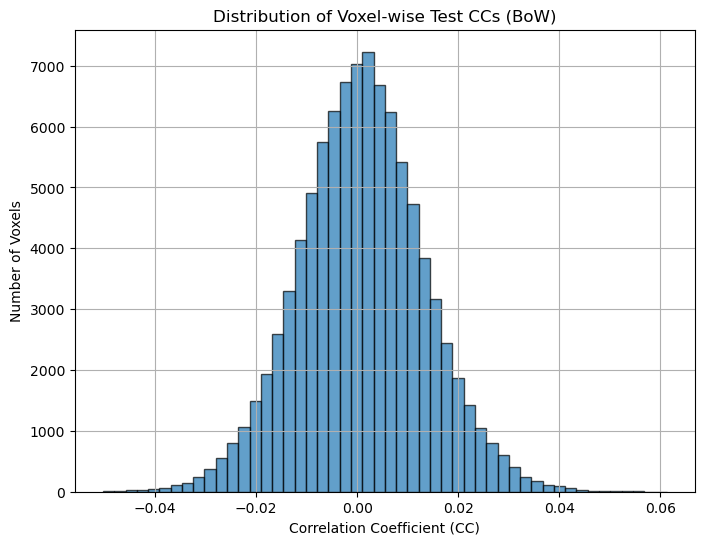

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(cc_test, bins=50, edgecolor='black', alpha=0.7)
plt.title("Distribution of Voxel-wise Test CCs (BoW)")
plt.xlabel("Correlation Coefficient (CC)")
plt.ylabel("Number of Voxels")
plt.grid(True)
plt.show()


In [13]:
model_filename = 'final_ridge_model.pkl'
with open(model_filename, 'rb') as f:
    loaded_model = pickle.load(f)
    
print(f"Model loaded from '{model_filename}'")

Model loaded from 'final_ridge_model.pkl'


In [ ]:
#test preds
X_test_best = embeddings['BoW']['X_test']
Y_test_pred = loaded_model.predict(X_test_best)

#voxel wise CC
cc_test = voxel_correlation(Y_test, Y_test_pred)

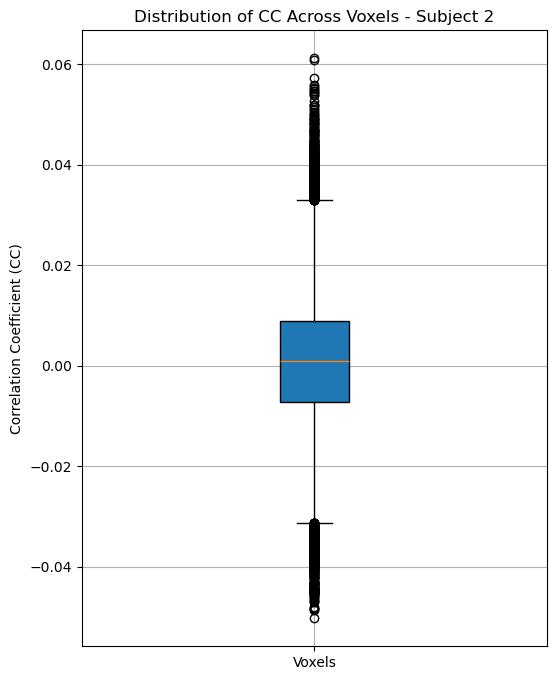

In [ ]:
#dist of CC across voxels
plt.figure(figsize=(6, 8))
plt.boxplot(cc_test, vert=True, patch_artist=True)
plt.title("Distribution of CC Across Voxels - Subject 2")
plt.ylabel("Correlation Coefficient (CC)")
plt.xticks([1], ['Voxels'])
plt.grid(True)
plt.show()

## Subject 3 Modeling

In [ ]:

best_embedding_method = "BoW"
best_alpha = 1000

print(f"Using best alpha = {best_alpha} for subject3 model training based on previous CV results.")

X_train_best = embeddings[best_embedding_method]['X_train']

#subject 3 training set
Y_train_subject3 = fmri_train['subject3']

#train Ridge model for subject 3 (separate from subject 2)
final_model_subj3 = Ridge(alpha=best_alpha)
final_model_subj3.fit(X_train_best, Y_train_subject3)
print("Final model for subject3 trained.")

X_test_best = embeddings[best_embedding_method]['X_test']
Y_test_subject3 = fmri_test['subject3']
Y_test_pred_subj3 = final_model_subj3.predict(X_test_best)

#voxel wise CC
cc_test_subj3 = voxel_correlation(Y_test_subject3, Y_test_pred_subj3)

test_mean_cc_subj3   = np.mean(cc_test_subj3)
test_median_cc_subj3 = np.median(cc_test_subj3)
test_top1_cc_subj3   = np.percentile(cc_test_subj3, 99)
test_top5_cc_subj3   = np.percentile(cc_test_subj3, 95)

print("\nSubject 3 Final Test Set Performance:")
print(f"  Mean CC:             {test_mean_cc_subj3:.4f}")
print(f"  Median CC:           {test_median_cc_subj3:.4f}")
print(f"  Top 1 Percentile CC: {test_top1_cc_subj3:.4f}")
print(f"  Top 5 Percentile CC: {test_top5_cc_subj3:.4f}")

#save the model for subject3
model_filename_subj3 = 'final_ridge_model_subject3.pkl'
with open(model_filename_subj3, 'wb') as f:
    pickle.dump(final_model_subj3, f)
print(f"Subject 3 final model saved to '{model_filename_subj3}'")


Using best alpha = 1000 for subject3 model training based on previous CV results.
Final model for subject3 trained.

Subject 3 Final Test Set Performance:
  Mean CC:             0.0017
  Median CC:           0.0014
  Top 1 Percentile CC: 0.0320
  Top 5 Percentile CC: 0.0213


OSError: [Errno 122] Disk quota exceeded

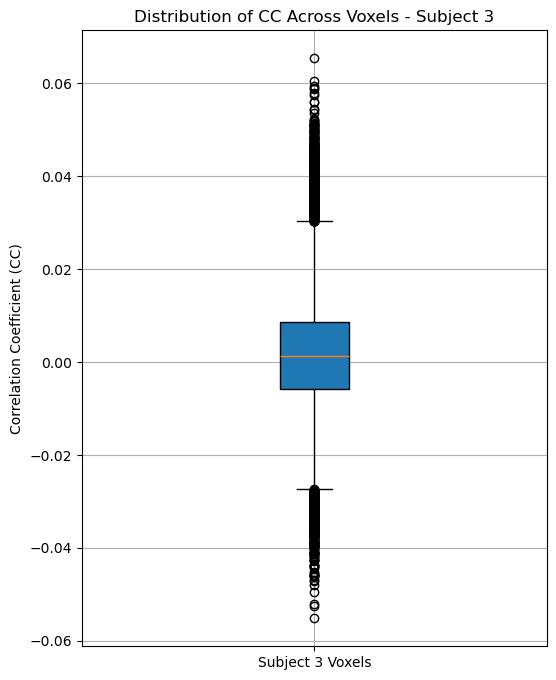

In [ ]:
import matplotlib.pyplot as plt

#CC across voxels for subject 3
plt.figure(figsize=(6, 8))
plt.boxplot(cc_test_subj3, vert=True, patch_artist=True)
plt.title("Distribution of CC Across Voxels - Subject 3")
plt.ylabel("Correlation Coefficient (CC)")
plt.xticks([1], ['Subject 3 Voxels'])
plt.grid(True)
plt.show()